In [1]:
# PS4 - CE264
# GSI: Mustapha Harb, Mengqiao Yu, Andrew Campbell

# importing the requried libraries
from collections import OrderedDict    # For recording the model specification 

import pandas as pd                    # For file input/output
import numpy as np                     # For vectorized math operations

import pylogit as pl                   # For MNL model estimation and
                                       # conversion from wide to long format

# reading the data file 
data_wide  = pd.read_csv("data01.csv",sep=",")

In [2]:
# converting the data from wide to long format

# Create the list of individual specific variables
ind_variables = data_wide.columns.tolist()[:2] + ["weights"]

# Specify the variables that vary across individuals and some or all alternatives
# The keys are the column names that will be used in the long format dataframe.
# The values are dictionaries whose key-value pairs are the alternative id and
# the column name of the corresponding column that encodes that variable for
# the given alternative. Examples below.
alt_varying_variables = {u'travel_time': dict([(1, 'tt_da'),
                                               (2, 'tt_sr'),
                                               (3, 'tt_walk'),
                                               (4, 'tt_bike'),
                                               (5, 'tt_wt'),
                                               (6, 'tt_dt')]),
                          u'distance_car': dict([(1, 'dist_car'),
                                                (2, 'dist_car')]),
                          u'travel_cost': dict([(1, 'cost_da'),
                                                (2, 'cost_sr'),
                                                (5, 'cost_wt'),
                                                (6, 'cost_dt')]),
                          u'access_time': dict([(5, 'accTime_wt'),
                                                (6, 'accTime_dt')]),
                          u'egress_time': dict([(5, 'egrTime_wt'),
                                                (6, 'egrTime_dt')]),
                          u'initial_wait': dict([(5, 'iWait_wt'),
                                                 (6, 'iWait_dt')]),
                          u'transfer_wait': dict([(5, 'xWait_wt'),
                                                  (6, 'xWait_dt')]),
                          u'access_distance_dt': dict([(6, "accDist_dt")])}

# Specify the availability variables
# Note that the keys of the dictionary are the alternative id's.
# The values are the columns denoting the availability for the
# given mode in the dataset.


availability_variables = {1: 'avail_da',
                          2: 'avail_sr', 
                          3: 'avail_walk',
                          4: 'avail_bike',
                          5: 'avail_wt',
                          6: 'avail_dt'}

##########
# Determine the columns for: alternative ids, the observation ids and the choice
##########
# The 'custom_alt_id' is the name of a column to be created in the long-format data
# It will identify the alternative associated with each row.
custom_alt_id = "mode_id"

# Create a custom id column that ignores the fact that this is a 
# panel/repeated-observations dataset. Note the +1 ensures the id's start at one.
obs_id_column = "obsID"

# Create a variable recording the choice column
choice_column = "choice"

In [3]:
# Perform the conversion to long-format
data_long = pl.convert_wide_to_long(data_wide, 
                                           ind_variables, 
                                           alt_varying_variables, 
                                           availability_variables, 
                                           obs_id_column, 
                                           choice_column,
                                           new_alt_id_name=custom_alt_id)
# Look at the resulting long-format dataframe
data_long.head(10).T

,0,1,2,3,4,5,6,7,8,9
obsID,1.0000,1.00000,2.0000,2.0000,2.00,2.000,3.0000,3.0000,3.000,4.0000
mode_id,1.0000,2.00000,1.0000,2.0000,4.00,6.000,1.0000,2.0000,6.000,1.0000
choice,1.0000,0.00000,0.0000,1.0000,0.00,0.000,1.0000,0.0000,0.000,0.0000
originTAZ,1308.0000,1308.00000,1269.0000,1269.0000,1269.00,1269.000,342.0000,342.0000,342.000,627.0000
destTAZ,1300.0000,1300.00000,1284.0000,1284.0000,1284.00,1284.000,429.0000,429.0000,429.000,583.0000
weights,21.0000,21.00000,51.5000,51.5000,51.50,51.500,37.0000,37.0000,37.000,137.0000
initial_wait,0.0000,0.00000,0.0000,0.0000,0.00,24.000,0.0000,0.0000,24.000,0.0000
travel_time,33.8500,33.85000,31.7100,31.7100,47.81,16.705,70.7700,70.7700,86.355,31.4800
travel_cost,1.9765,0.98824,2.5306,1.2653,0.00,4.240,6.8065,3.4032,6.010,2.6929
egress_time,0.0000,0.00000,0.0000,0.0000,0.00,26.350,0.0000,0.0000,39.620,0.0000


In [4]:
##########
# Create scaled variables so the estimated coefficients are of similar magnitudes
##########
# Scale the travel time column by 60 to convert raw units (minutes) to hours
data_long["travel_time_hrs"] = data_long["travel_time"] / 60.0

# Scale the access by 60 to convert raw units (minutes) to hours
data_long["access_time_hrs"] = data_long["access_time"] / 60.0

# for drive to transit let us combine travel time and access time
data_long["travel_time_access_time_hrs"] = data_long["travel_time_hrs"] + data_long["access_time_hrs"]

#Scale the egress time by 60
data_long["egress_time_hrs"] = data_long["egress_time"] / 60.0

# combining access and egress time which we want to use for the walk to transit alternative
data_long["acess_egress_hrs"] = data_long["access_time_hrs"] + data_long["egress_time_hrs"]

# scaling the initial wait by 60
data_long["initial_wait_hrs"] = data_long["initial_wait"] / 60.0

# scaling the transfer wait by 60
data_long["transfer_wait_hrs"]  = data_long["transfer_wait"] / 60.0

# combining transfer wait and initial wait to be used for walk to transit and bike to transit
data_long["initial_transfer_wait_hrs"] = data_long["initial_wait_hrs"] + data_long["transfer_wait_hrs"]


# creating non-linear transformations for the cost variable
cutOff1 = 2
cutOff2 = 7


data_long["cost_cat_one"] = (data_long["travel_cost"] <= cutOff1)*data_long["travel_cost"] + (data_long["travel_cost"] > cutOff1)*cutOff1

data_long["cost_cat_two"] = (data_long["travel_cost"] > cutOff1)*(data_long["travel_cost"] <= cutOff2)*(data_long["travel_cost"] - cutOff1) + (data_long["travel_cost"] > cutOff2)* (cutOff2 - cutOff1)

data_long["cost_cat_three"] = (data_long["travel_cost"] > cutOff2)*(data_long["travel_cost"] - cutOff2)



# specifying the utility equations

# NOTE: - Specification and variable names must be ordered dictionaries.
#       - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         of integers or or lists of lists of integers. Within a list, 
#         or within the inner-most list, the integers should be the 
#         alternative ID's of the alternative whose utility specification 
#         the explanatory variable is entering. Lists of lists denote 
#         alternatives that will share a common coefficient for the variable
#         in question.

basic_specification = OrderedDict()
basic_names = OrderedDict()


basic_specification["intercept"] = [ 2, 3, 4, 5, 6]
basic_names["intercept"] = ['ASC SR',
                            'ASC Walk', 'ASC Bike', 'ASC WT', 'ASC DT']

basic_specification["travel_time_hrs"] = [[1, 2, 5], 4, 3]
basic_names["travel_time_hrs"] = ['In-Vehicle Travel Time, units:hrs (DA, SR, WT)',
                                  'Bike Time, units:hrs (Bike)',
                                  'Walk Time, units:hrs (Walk)']

basic_specification["travel_time_access_time_hrs"] = [6]
basic_names["travel_time_access_time_hrs"] = ["In-Vehicle Travel Time, units:hrs, (DT)"]

basic_specification["acess_egress_hrs"] = [5]
basic_names["acess_egress_hrs"] = ["Walk Time, units:hrs, (WT)"]

basic_specification["egress_time_hrs"] = [6]
basic_names["egress_time_hrs"] = ["Walk Time, units:hrs, (DT)"]

basic_specification["initial_transfer_wait_hrs"] = [[5, 6]]
basic_names["initial_transfer_wait_hrs"] = ["Waiting Time, units:hrs, (WT and DT)"]


basic_specification["cost_cat_one"] = [[1, 2, 5,6]]
basic_names["cost_cat_one"] = ['Cost: Under $2']

basic_specification["cost_cat_two"] = [[1, 2, 5,6]]
basic_names["cost_cat_two"] = ['Cost: (2 - 7)$']

basic_specification["cost_cat_three"] = [[1, 2, 5,6]]
basic_names["cost_cat_three"] = ['Cost: Above $7']



/home/Carlin/anaconda3/envs/python2/lib/python2.7/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [59]:
# taking a sample of 10,000 observation from the BATS 2000 dataset
new_data = data_long.loc[data_long[obs_id_column].isin(range(10000))].copy()
print len(new_data)

In [6]:
# Estimate the multinomial logit model (MNL)
data_mnl = pl.create_choice_model(data=new_data,
                                  alt_id_col=custom_alt_id,
                                  obs_id_col=obs_id_column,
                                  choice_col=choice_column,
                                  specification=basic_specification,
                                  model_type="MNL",
                                  names=basic_names)

# Specify the initial values and method for the optimization.
data_mnl.fit_mle(np.zeros(15))



Log-likelihood at zero: -12,766.7933
Initial Log-likelihood: -12,766.7933


/home/Carlin/anaconda3/envs/python2/lib/python2.7/site-packages/scipy/optimize/_minimize.py:420: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 4.12 seconds.
Final log-likelihood: -8,020.8080


In [7]:
# Look at the estimation results
data_mnl.get_statsmodels_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                9,999
Model:             Multinomial Logit Model   Df Residuals:                    9,984
Method:                                MLE   Df Model:                           15
Date:                     Mon, 05 Mar 2018   Pseudo R-squ.:                   0.372
Time:                             22:07:50   Pseudo R-bar-squ.:               0.371
AIC:                            16,071.616   Log-Likelihood:             -8,020.808
BIC:                            16,179.770   LL-Null:                   -12,766.793
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
ASC SR                                            -2.1158      0.049    -43.217      0.000      -2.212      -2.020
ASC Walk                                          -2.5376      0.187    -13.546      0.000      -2.905      -2.170
ASC Bike                                          -3.4882      0.185    -18.852      0.000      -3.851      -3.126
ASC WT                                             1.5572      0.154     10.133      0.000       1.256       1.858
ASC DT                                            -0.8970      0.183     -4.893      0.000      -1.256      -0.538
In-Vehicle Travel Time, units:hrs (DA, SR, WT)    -1.9053      0.094    -20.306      0.000      -2.089      -1.721
Bike Time, units:hrs (Bike)                       -4.7177      0.361    -13.058      0.000      -5.426      -4.010
Walk Time, units:hrs (Walk)                       -1.1014      0.122     -9.012      0.000      -1.341      -0.862
In-Vehicle Travel Time, units:hrs, (DT)           -1.2238      0.121    -10.149      0.000      -1.460      -0.987
Walk Time, units:hrs, (WT)                        -3.1670      0.227    -13.968      0.000      -3.611      -2.723
Walk Time, units:hrs, (DT)                        -5.2712      0.384    -13.732      0.000      -6.024      -4.519
Waiting Time, units:hrs, (WT and DT)              -2.6341      0.225    -11.705      0.000      -3.075      -2.193
Cost: Under $2                                    -1.2832      0.064    -20.084      0.000      -1.408      -1.158
Cost: (2 - 7)$                                    -0.3359      0.019    -17.883      0.000      -0.373      -0.299
Cost: Above $7                                    -0.0781      0.010     -7.976      0.000      -0.097      -0.059
==================================================================================================================
"""

In [8]:
# prediction - sample enumeration
# array of probabilities for each available alternative for all individuals in the new_data file that 
# was used for estimation
prediction_array = data_mnl.predict(new_data)

In [9]:
# check out the probabilities
prediction_array

array([0.70008415, 0.29991585, 0.71308952, ..., 0.78970481, 0.19250572,
       0.01778947])

In [54]:
# market shares
# the following script performs sample enumeration for all alternatives by catering for individual weights 

total_weights = np.sum(data_wide.loc[:9999, 'weights'])
weights = new_data["weights"] / total_weights

alternative_names = ["drive", "shared ride", "walk", "bike",
                     "walk transit", "drive transit"]
num_alternatives = data_long["mode_id"].unique().size
market_shares = np.empty(num_alternatives)
for i in range(1, 7):
    filter_condition = (new_data["mode_id"] == i).values
    num_obs_in_condition = filter_condition.sum()
    current_weights = weights[filter_condition]
    assert current_weights.size == num_obs_in_condition
    current_alternative_share =\
        prediction_array[filter_condition].dot(current_weights)
    market_shares[i - 1] = current_alternative_share
    
pd.Series(market_shares, index=alternative_names)

drive            0.631724
shared ride      0.224905
walk             0.017962
bike             0.014922
walk transit     0.070864
drive transit    0.039549
dtype: float64

In [55]:
np.sum(weights)

3.8338610682418888

In [56]:
total_weights

901968.0

In [57]:
np.sum(prediction_array)

9999.0

In [60]:
len(new_data)

37921

In [50]:
print np.sum(new_data["weights"] / total_weights)

3.8338610682418888


In [52]:
print np.sum(n_data['weights']/np.sum(data_wide.loc[:(len(n_data)-1), 'weights']))

0.9502208948050217


## 2 and 3

In [97]:
# select for only those in the correct TAZ
n_data = data_long.loc[np.logical_or(data_long['originTAZ'] <= 42, data_long['destTAZ'] <= 42)].copy()

# identify those who are driving in any way, shape, or form during their commute
n_data['driving'] = n_data['mode_id'].isin([1,2,6])

# initialize dataframes to hold desired results
prob_evo = pd.DataFrame(columns=alternative_names)
emis_evo = pd.DataFrame(columns=['CO2 Emissions'])

for i in range(11):
    temp_data = n_data.copy()
    
    # increase travel cost but only if they're driving
    temp_data.loc[temp_data['driving'],'travel_cost'] += i
    
    # should check if they drove to reduce calculations done, but would have no effect on the end result (since those costs don't change) so whatever
    temp_data["cost_cat_one"] = (temp_data["travel_cost"] <= cutOff1)*temp_data["travel_cost"] + (temp_data["travel_cost"] > cutOff1)*cutOff1
    temp_data["cost_cat_two"] = (temp_data["travel_cost"] > cutOff1)*(temp_data["travel_cost"] <= cutOff2)*(temp_data["travel_cost"] - cutOff1) + (temp_data["travel_cost"] > cutOff2)* (cutOff2 - cutOff1)
    temp_data["cost_cat_three"] = (temp_data["travel_cost"] > cutOff2)*(temp_data["travel_cost"] - cutOff2)
    
    # predict
    predic_array = data_mnl.predict(temp_data)
    
    # get the market shares by performing sample enumeration for all alternatives by catering for individual weights 
    weights = temp_data["weights"] / total_weights
    market_shares = np.empty(num_alternatives)
    for j in range(1, 7):
        filter_condition = (temp_data["mode_id"] == j).values
        num_obs_in_condition = filter_condition.sum()
        current_weights = weights[filter_condition]
        assert current_weights.size == num_obs_in_condition
        current_alternative_share = predic_array[filter_condition].dot(current_weights)
        market_shares[j - 1] = current_alternative_share
    prob_evo.loc[i] = pd.Series(market_shares, index=alternative_names)
    
    # calculate total carbon emitted
    emis_evo.loc[i] = pd.Series(np.dot(temp_data['distance_car'], # distance in mi traveled by car if going by car (otherwise 0)
                                predic_array)  # likelihood of going by car
                                *0.916, index=['CO2 Emissions'])  # CO2 emissions per mi traveled
    
prob_evo = prob_evo / np.sum(prob_evo.loc[0,]) # scale to 100% sum
prob_evo

,drive,shared ride,walk,bike,walk transit,drive transit
0,0.341571,0.129158,0.030380,0.014138,0.339554,0.145198
1,0.289843,0.087568,0.046439,0.020854,0.426325,0.128971
2,0.267772,0.070666,0.053033,0.023815,0.469995,0.114720
3,0.254823,0.062141,0.055619,0.025564,0.497248,0.104604
4,0.241792,0.055963,0.057707,0.027038,0.518459,0.099042
5,0.229634,0.052201,0.059337,0.028152,0.533772,0.096904
6,0.221378,0.049745,0.060518,0.028794,0.544612,0.094954
7,0.215902,0.048388,0.060982,0.029104,0.552597,0.093026
8,0.211086,0.047387,0.061207,0.029338,0.559862,0.091120
9,0.206371,0.046409,0.061418,0.029562,0.567007,0.089233


In [98]:
emis_evo

,CO2 Emissions
0,41101.357428
1,39709.582004
2,39195.000077
3,38642.826568
4,38003.007717
5,37343.887813
6,36807.379309
7,36344.657515
8,35891.905061
9,35440.695938


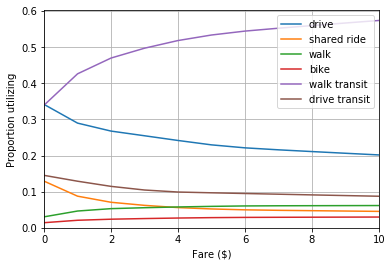

In [117]:
import matplotlib.pyplot as plt

for col in prob_evo:
    plt.plot(prob_evo.index, prob_evo[col], label=col)
plt.grid()
plt.xlabel('Fare ($)')
plt.ylabel('Proportion utilizing')
plt.ylim(ymin=0)
plt.xlim(0,10)
plt.legend()

plt.show()

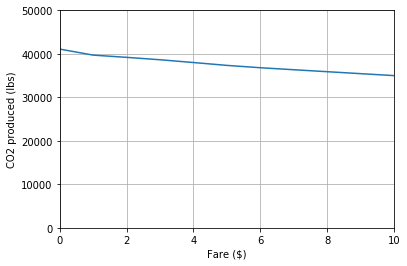

In [119]:
plt.plot(emis_evo.index, emis_evo)
plt.grid()
plt.xlabel('Fare ($)')
plt.ylabel('CO2 produced (lbs)')
plt.xlim(0,10)
plt.ylim(0, 50000)
plt.show()